# Projet M1 ISI: Apprentissage auto-supervisé de représentations audio pour l'exploration de paysages sonores

In [1]:
%cd /content
# On télécharge le bibliothèque WavTokenizer (on clone le repo git)
!git clone https://github.com/jishengpeng/WavTokenizer.git
%cd WavTokenizer

# On importe le constructeur et le convertisseur audio (WavTokenizer prend des fichiers audios de Fs=24kHz)
from decoder.pretrained import WavTokenizer
from encoder.utils import convert_audio

%cd /content

# On télécharge le modèle de WavTokenizer que nous allons utiliser
!wget https://huggingface.co/novateur/WavTokenizer-large-speech-75token/resolve/main/wavtokenizer_large_speech_320_v2.ckpt -O /content/WavTokenizer/large_model.ckpt
# Possibilité de telecharger un autre modele => cf. wavtokenizer_large_unify_600_24k? (config 40tok/s)

/content
Cloning into 'WavTokenizer'...
remote: Enumerating objects: 200, done.
remote: Counting objects: 100% (114/114), done.
remote: Compressing objects: 100% (80/80), done.
remote: Total 200 (delta 65), reused 34 (delta 34), pack-reused 86 (from 2)
Receiving objects: 100% (200/200), 469.26 KiB | 3.61 MiB/s, done.
Resolving deltas: 100% (83/83), done.
/content/WavTokenizer
/content
--2025-06-20 12:49:52--  https://huggingface.co/novateur/WavTokenizer-large-speech-75token/resolve/main/wavtokenizer_large_speech_320_v2.ckpt
Resolving huggingface.co (huggingface.co)... 18.172.134.88, 18.172.134.124, 18.172.134.4, ...
Connecting to huggingface.co (huggingface.co)|18.172.134.88|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/83/44/83442801d7c06ef2d684a7739c4037681c8f03b9349342d3cbe9e0ae7c0b93a6/5dd430d5f0d96e2313babb1b896d0f990b65bfd143b2894fc3851cfc3cca9846?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27wavtok

In [2]:
# On télécharge le dossier comprésé contenant les tokens calculés au préalable
%cd /content/
import os
zip_path = "/content/esc50_tokens_WavTokenizer.zip"

# Extraction des tokens (si téléchargés)
if not os.path.exists(zip_path):
    !wget https://raw.githubusercontent.com/GhilesREDJDAL/Projet-M1-ISI-SSL-paysages-sonores/main/esc50_tokens_WavTokenizer.zip
    !unzip {zip_path} -d /content

/content
--2025-06-20 12:50:08--  https://raw.githubusercontent.com/GhilesREDJDAL/Projet-M1-ISI-SSL-paysages-sonores/main/esc50_tokens_WavTokenizer.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2969568 (2.8M) [application/zip]
Saving to: ‘esc50_tokens_WavTokenizer.zip’

esc50_tokens_WavTok 100%[===================>]   2.83M  --.-KB/s    in 0.08s   

2025-06-20 12:50:08 (37.4 MB/s) - ‘esc50_tokens_WavTokenizer.zip’ saved [2969568/2969568]

Archive:  /content/esc50_tokens_WavTokenizer.zip
   creating: /content/esc50_tokens_WavTokenizer/
  inflating: /content/esc50_tokens_WavTokenizer/1-100032-A-0.pt  
  inflating: /content/esc50_tokens_WavTokenizer/1-100038-A-14.pt  
  inflating: /content/esc50_tokens_WavTokenizer/1-100210-A-36.pt  
  inflating: /content

In [3]:
# Import des bibliothèques utilisées
import torch
import torchaudio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm # Pour la barre de progression (inference et parcours des fichiers)
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN

In [4]:
# On télécharge le dataset sur lequel nous effectuons nos tests
# Autres datasets à tester: FSC-22, EFSC-24 (plus orientés fôrets, à trouver)
%cd /content
!git clone https://github.com/karolpiczak/ESC-50.git
%cd ESC-50
%cd /content/
audio_dir = "/content/ESC-50/audio"
meta_csv = "/content/ESC-50/meta/esc50.csv"

metadata = pd.read_csv(meta_csv)

/content
Cloning into 'ESC-50'...
remote: Enumerating objects: 4199, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 4199 (delta 62), reused 34 (delta 34), pack-reused 4130 (from 1)
Receiving objects: 100% (4199/4199), 878.77 MiB | 31.63 MiB/s, done.
Resolving deltas: 100% (292/292), done.
Updating files: 100% (2011/2011), done.
/content/ESC-50
/content


In [5]:
# Détermine le périphérique à utiliser (GPU si disponible, sinon CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Chemin vers le fichier de configuration du modèle WavTokenizer
config_path = "/content/WavTokenizer/configs/wavtokenizer_smalldata_frame75_3s_nq1_code4096_dim512_kmeans200_attn.yaml"
# Chemin vers le fichier du modèle pré-entraîné WavTokenizer
model_path = "/content/WavTokenizer/large_model.ckpt"

# Charge le modèle WavTokenizer:
wavtokenizer = WavTokenizer.from_pretrained0802(config_path, model_path)

/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, dim)


In [ ]:
# Inference: pas besoin de refaire, les tokens sont fournit dans le fichier .zip
"""
# Répertoire de sortie pour les tokens
output_dir_tok = "/content/esc50_tokens_WavTokenizer"
# Répertoire de sortie pour les features (commenté, car non utilisé)
#output_dir_features = "/content/esc50_features_WavTokenizer"

# Crée les répertoires de sortie s'ils n'existent pas déjà
# os.makedirs(output_dir_features, exist_ok=True) # Commenté car output_dir_features n'est pas utilisé
os.makedirs(output_dir_tok, exist_ok=True)

# Déplace le modèle WavTokenizer sur le périphérique sélectionné (GPU ou CPU)
wavtokenizer = wavtokenizer.to(device)

# On boucle sur chaque fichier audio dans le répertoire d'audio
for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    # Extrait le nom du fichier audio et construit le chemin complet
    filename = row["filename"]
    path = os.path.join(audio_dir, filename)

    # Traitement du fichier audio
    try:
        # Charge le waveform et le taux d'échantillonnage
        waveform, sr = torchaudio.load(path)
        # Convertit le waveform au format requis par WavTokenizer (24kHz, mono)
        waveform = convert_audio(waveform, sr, 24000, 1).to(device)
        bandwidth_id = torch.tensor([0]).to(device)

        # Encode le waveform pour obtenir les features et les codes discrets
        features, discrete_code = wavtokenizer.encode_infer(waveform, bandwidth_id=bandwidth_id)

        # Construit les chemins de sortie pour les tokens et les features
        token_path = os.path.join(output_dir_tok, filename.replace(".wav", ".pt"))
        # feature_path = os.path.join(output_dir_features, filename.replace(".wav", ".pt")) # Commenté car non utilisé

        # Sauvegarde les codes discrets (tokens)
        torch.save(discrete_code.cpu(), token_path)
        # Sauvegarde les features (commenté, car non utilisé)
        #torch.save(features.cpu(), feature_path) # Pas besoin de sauvegarder les features (utilisation de code_to_features)

    # Gère les exceptions qui peuvent survenir lors du traitement d'un fichier audio
    except Exception as e:
        # Affiche un message d'erreur si un problème survient
        print(f"Error with {filename}: {e}")
"""

WavTokenizer attribue à chaque fichier audio une séquence de tokens (40 ou 75 tokens par secondes), où chaque token représente une ligne dans un codebook, cette ligne correspondant à une représentation audio pré-apprise lors de l'entrainement (feature).
Les features extraites directement par WavTokenizer sont identiques à celles obtenues en utilisant la fonction codes_to_features sur les codes discrets (tokens). C'est pourquoi les features brutes n'ont pas été utilisées ou enregistrées séparément dans ce notebook, car les vecteurs du codebook dérivés des tokens fournissent les mêmes informations pour l'analyse.

In [6]:
# Rrépertoire contenant les tokens enregistrés
tokens_dir = '/content/esc50_tokens_WavTokenizer'
# Répertoire contenant les features enregistrées (commenté)
#features_dir = '/content/esc50_features_WavTokenizer'

# Charge les métadonnées du dataset ESC-50
meta_df = pd.read_csv('/content/ESC-50/meta/esc50.csv')
# Remplace l'extension '.wav' par '.pt' dans la colonne 'filename' pour correspondre aux fichiers de tokens
meta_df['filename'] = meta_df['filename'].str.replace('.wav', '.pt')

# Initialise des listes vides pour stocker différentes informations sur les tokens et features (selon les cas)
#all_tokens = []
tok_seq = []
#all_tok_per_file = []
#max_tokens = []
#mean_tokens = []
#feat_vectors_all = []
codebook_vectors_all = []
cb_vect_all = []
file_data_list = []

# On recupère la liste des nom de fichiers
filenames_list = [f for f in os.listdir(tokens_dir) if f.endswith('.pt')] # Ignore les fichiers qui ne se terminent pas par '.pt'
filenames_list.sort() # Sort car os.listdir ne founit pas une liste de fichier constante, elle peut varier dans le temps

# Boucle sur chaque fichier dans le répertoire des tokens
for fname in tqdm(filenames_list):
    # Construit le chemin complet du fichier de tokens
    tok_path = os.path.join(tokens_dir, fname)
    # Charge les tokens à partir du fichier
    tokens = torch.load(tok_path)

    """
    # Charge les features à partir du fichier
    #feat_path = os.path.join(features_dir, fname)
    #features = torch.load(feat_path)

    # Reforme et transpose les features
    #features = features.squeeze(0).transpose(0, 1)
    """

    # Convertit les codes discrets (tokens) en vecteurs de features du codebook
    decoded_feats = wavtokenizer.codes_to_features(tokens)
    # Reforme et transpose les vecteurs de features décodés
    decoded_feats = decoded_feats.squeeze(0).transpose(0, 1)

    """
    # Met à jour le dictionnaire correspondant au fichier actuel et l'ajoute à la liste
    file_data = {
        'filename': fname,
        'tokens': tokens.squeeze(),
        'decoded_features': decoded_feats.numpy(),
        'category': None
    }
    file_data_list.append(file_data)
    """

    # Ajoute les vecteurs de features décodés (convertis en NumPy) à la liste temporaire
    cb_vect_all.append(decoded_feats.numpy())  # <----
    # Ajoute les vecteurs de features originaux
    #feat_vectors_all.append(features.numpy())
    # Ajoute la séquence de tokens (aplatie) à la liste
    tok_seq.append(tokens.squeeze()) # <----
    """
    # Calcule et ajoute le maximum de tokens
    max_tokens.append([tokens.max()])
    # Calcule et ajoute la moyenne des tokens
    mean_tokens.append([torch.mean(tokens.float()).to(torch.int64)])

    # Ajoute chaque token individuel à la liste
    for tok in tokens:
      all_tokens.append([tok.numpy()])
    # Ajoute le tableau NumPy de tokens par fichier à la liste
    all_tok_per_file.append(tokens.numpy())
    """
# Concatène verticalement les vecteurs de features originaux en un seul tableau NumPy
#feat_vectors_all = np.vstack(feat_vectors_all)
# Concatène verticalement les vecteurs de features décodés (du codebook) en un seul tableau NumPy
codebook_vectors_all = np.vstack(cb_vect_all)# <----
# Concatène verticalement les séquences de tokens
tok_seq = np.vstack(tok_seq)# <----

100%|██████████| 2000/2000 [00:04<00:00, 413.31it/s]


In [ ]:
"""
print(len(file_data_list))
print(np.shape(np.vstack([file_data['tokens'] for file_data in file_data_list])))
print(np.shape(tok_seq))

print(np.shape(codebook_vectors_all))
print(np.shape(np.vstack([file_data['decoded_features'] for file_data in file_data_list])))
"""

In [ ]:
# Test égalité features extraites et features retrouvé par token
"""
features_dir = '/content/esc50_features_WavTokenizer'
!unzip /content/esc50_features_WavTokenizer.zip -d /content
#test = torch.load('/content/esc50_features_WavTokenizer/1-100032-A-0.pt').squeeze(0).transpose(0, 1).numpy()
#test_np = test.numpy()
#print(test.shape)
codebook_vectors_all = codebook_vectors_all.reshape((2000,375,512))
#print(codebook_vectors_all[0].shape)

cpt = 0
cpt_file = 0
for fname in tqdm(os.listdir(features_dir)):
  if not fname.endswith('.pt'):
    continue
  feat_path = os.path.join(features_dir, fname)
  features = torch.load(feat_path).squeeze(0).transpose(0, 1).numpy()
  if not np.array_equal(features, codebook_vectors_all[cpt_file]):
    cpt += 1
  cpt_file += 1
print()
print("Différences: ", cpt)
"""

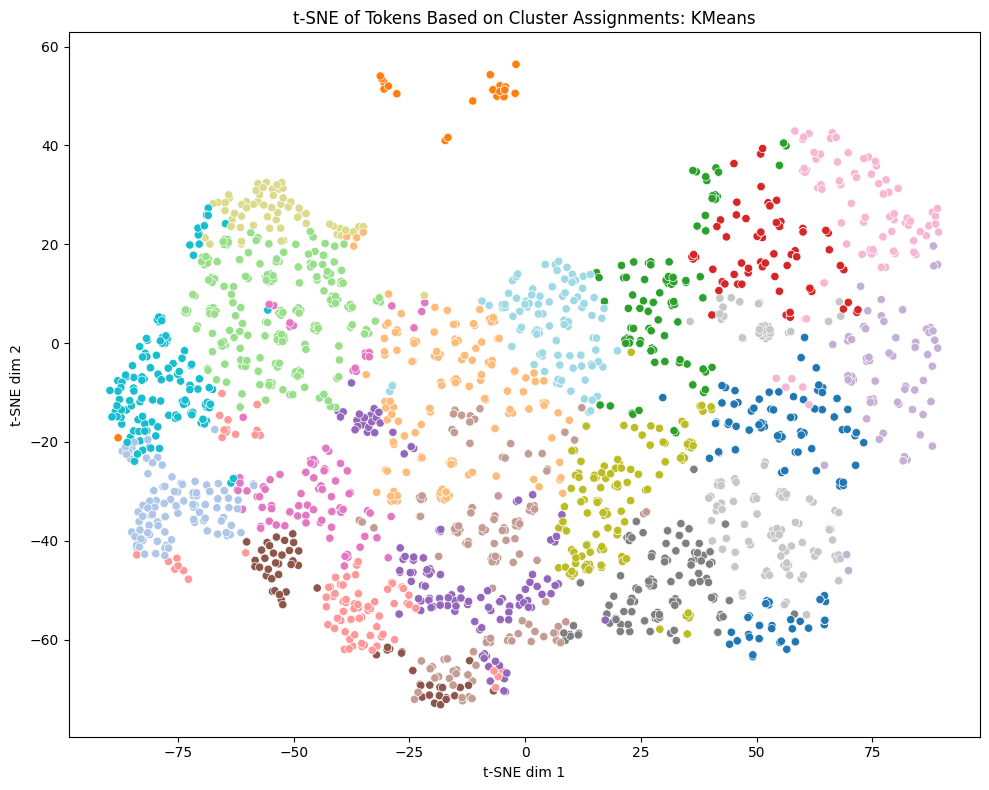

In [7]:
# Problématique car taille totale (750000,512)
# On regroupe ici les features correspondantes au 10 premier fichiers (3750, 512) (saturation de la RAM si sur l'ensemble)
# Nombre de clusters pour KMeans
n_clusters = 20
# Initialise et entraîne un modèle KMeans sur les vecteurs du codebook
kmeans_cb = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_cb.fit(codebook_vectors_all[:375*10,:])


# Applique t-SNE sur les vecteurs du codebook et obtient les résultats pour chaque algorithme de clustering
resh_tsne_cb = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(codebook_vectors_all[:375*10,:])

# Crée et affiche un scatter plot des résultats t-SNE colorés par les clusters KMeans
plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_cb[:, 0], y=resh_tsne_cb[:, 1], hue= kmeans_cb.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: KMeans")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

# """
# # Initialise et entraîne un modèle DBSCAN sur les vecteurs du codebook
# dbscan_cb = DBSCAN(eps=0.5, min_samples=5)
# dbscan_cb.fit(codebook_vectors_all[:375*10,:])

# # Crée et affiche un scatter plot des résultats t-SNE colorés par les clusters DBSCAN
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=resh_tsne_cb[:, 0], y=resh_tsne_cb[:, 1], hue= dbscan_cb.labels_, palette='tab20', legend=False)
# plt.title("t-SNE of Tokens Based on Cluster Assignments: DBSCAN")
# plt.xlabel("t-SNE dim 1")
# plt.ylabel("t-SNE dim 2")
# plt.tight_layout()
# plt.show()

# # Initialise et entraîne un modèle HDBSCAN sur les vecteurs du codebook
# hdbscan_cb = HDBSCAN(min_cluster_size=5)
# hdbscan_cb.fit(codebook_vectors_all[:375*10,:])

# # Crée et affiche un scatter plot des résultats t-SNE colorés par les clusters HDBSCAN
# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=resh_tsne_cb[:, 0], y=resh_tsne_cb[:, 1], hue= hdbscan_cb.labels_, palette='tab20', legend=False)
# plt.title("t-SNE of Tokens Based on Cluster Assignments: HDBSCAN")
# plt.xlabel("t-SNE dim 1")
# plt.ylabel("t-SNE dim 2")
# plt.tight_layout()
# plt.show()
# """

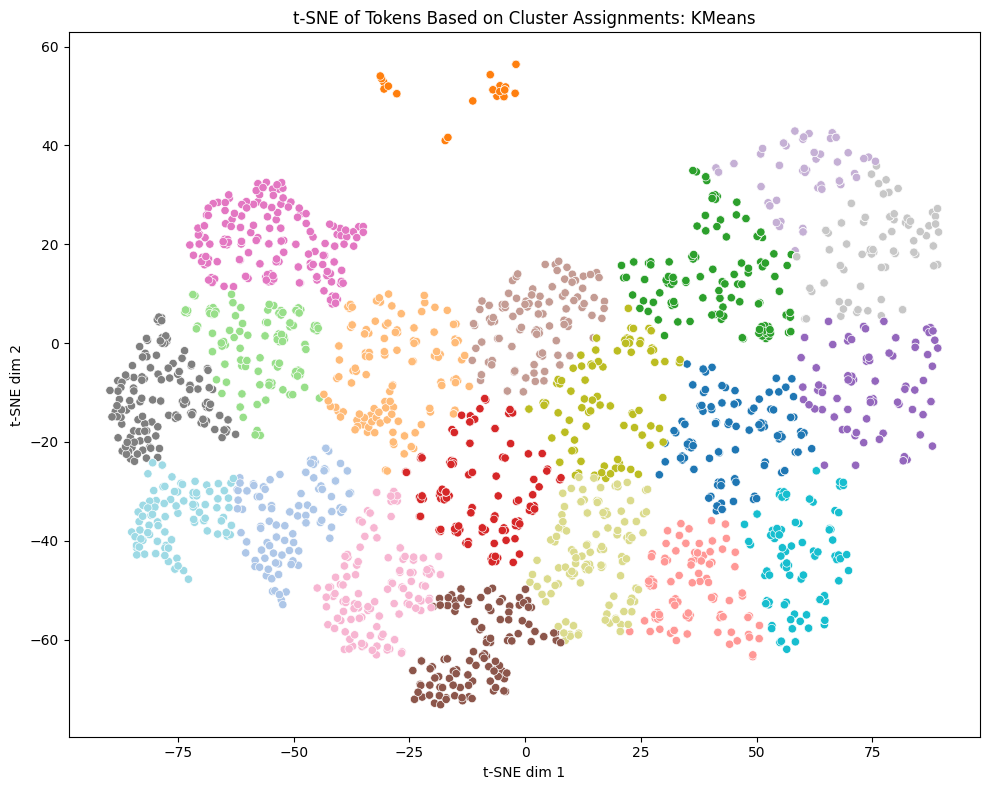

In [8]:
# Problématique car taille totale (750000,512)
# TEST clustering sur embeddings resultant de la TSNE --- 3750 premiere features (3750, 512)---
# Applique t-SNE sur les vecteurs du codebook et obtient les résultats pour chaque algorithme de clustering
#resh_tsne_cb = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(codebook_vectors_all[:375*10,:])

kmeans_tsne_cb = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_tsne_cb.fit(resh_tsne_cb)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_cb[:, 0], y=resh_tsne_cb[:, 1], hue= kmeans_tsne_cb.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: KMeans")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

# """
# dbscan_tsne_cb = DBSCAN(eps=0.5, min_samples=5)
# dbscan_tsne_cb.fit(resh_tsne_cb)

# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=resh_tsne_cb[:, 0], y=resh_tsne_cb[:, 1], hue= dbscan_tsne_cb.labels_, palette='tab20', legend=False)
# plt.title("t-SNE of Tokens Based on Cluster Assignments: DBSCAN")
# plt.xlabel("t-SNE dim 1")
# plt.ylabel("t-SNE dim 2")
# plt.tight_layout()
# plt.show()

# hdbscan_tsne_cb = HDBSCAN(min_cluster_size=5)
# hdbscan_tsne_cb.fit(resh_tsne_cb)

# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=resh_tsne_cb[:, 0], y=resh_tsne_cb[:, 1], hue= hdbscan_tsne_cb.labels_, palette='tab20', legend=False)
# plt.title("t-SNE of Tokens Based on Cluster Assignments: HDBSCAN")
# plt.xlabel("t-SNE dim 1")
# plt.ylabel("t-SNE dim 2")
# plt.tight_layout()
# plt.show()
# """

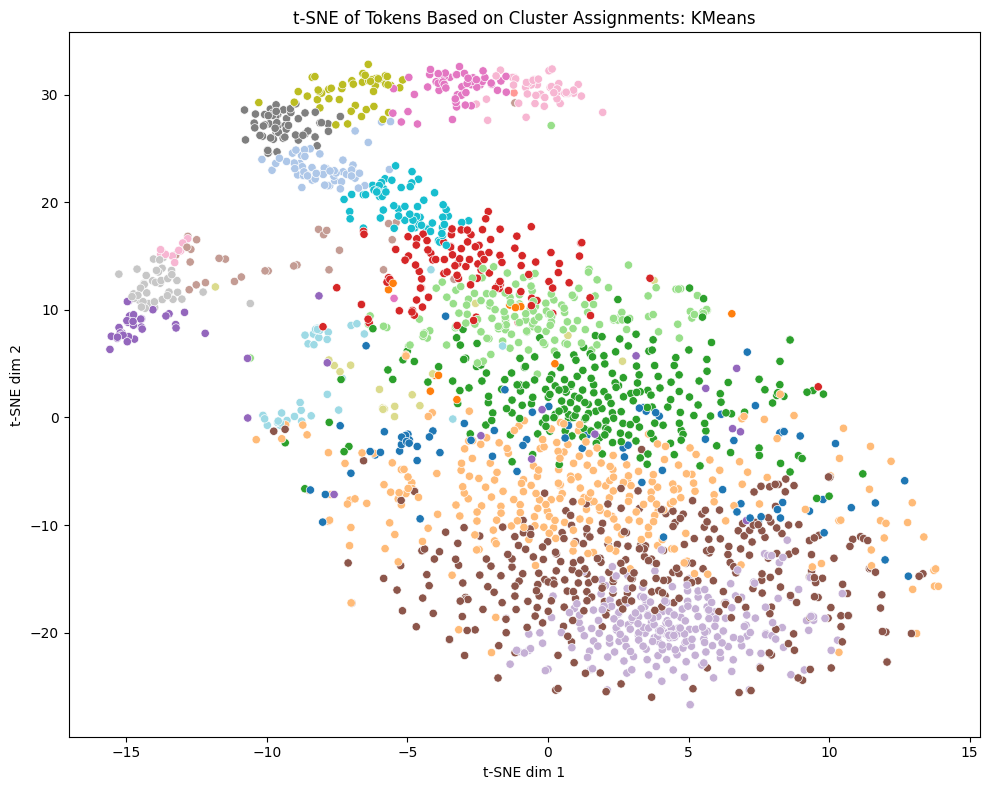

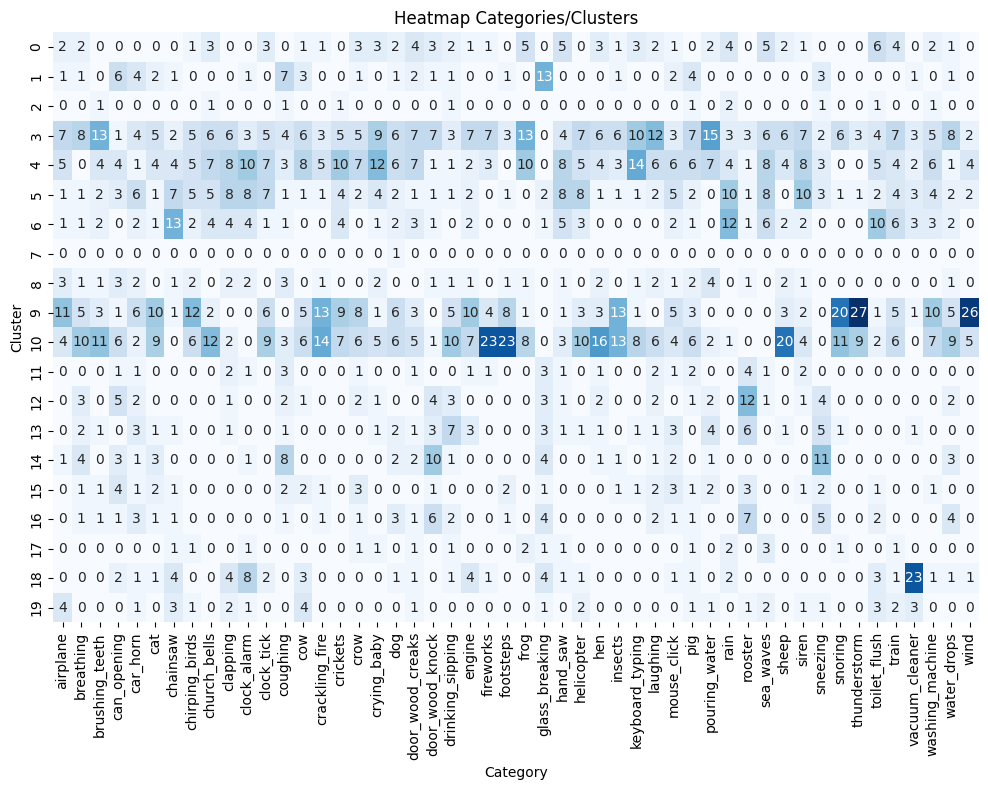

In [9]:
# Clustering sequence de tokens (2000, 375): C
# Nombre de clusters
n_clusters = 20
# Applique KMeans sur les séquences de tokens
"""
# Avec accès au dictionnaire file_data_list:
tok_seq = np.vstack([file_data['tokens'] for file_data in file_data_list])
"""
kmeans_files = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_files.fit(tok_seq)

"""
# Example attribution cluster pour chaque fichier:

for i, file_data in enumerate(files_data_list):
    file_data['class'] = kmeans_files.labels_[i]

"""


# Applique t-SNE sur les séquences de tokens pour chaque algorithme de clustering
resh_tsne_files = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(tok_seq)

# Affiche le t-SNE des séquences de tokens coloré par les clusters KMeans
plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_files[:, 0], y=resh_tsne_files[:, 1], hue= kmeans_files.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: KMeans")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

"""
# Applique DBSCAN sur les séquences de tokens
dbscan_files = DBSCAN(eps=0.5, min_samples=5)
dbscan_files.fit(tok_seq)

# Affiche le t-SNE des séquences de tokens coloré par les clusters DBSCAN
plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_files[:, 0], y=resh_tsne_files[:, 1], hue= dbscan_files.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: DBSCAN")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

# Applique HDBSCAN sur les séquences de tokens
hdbscan_files = HDBSCAN(min_cluster_size=5)
hdbscan_files.fit(tok_seq)

# Affiche le t-SNE des séquences de tokens coloré par les clusters HDBSCAN
plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_files[:, 0], y=resh_tsne_files[:, 1], hue= hdbscan_files.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: HDBSCAN")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()
"""

kmeans_labels = kmeans_files.labels_

gt_cat = np.array(meta_df['category'])

cats_in_clusters =  pd.DataFrame({'cluster': kmeans_labels, 'category': gt_cat})

cluster_comp = pd.crosstab(cats_in_clusters['cluster'], cats_in_clusters['category'])

plt.figure(figsize=(10, 8))
sns.heatmap(cluster_comp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Heatmap Categories/Clusters")
plt.xlabel("Category")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

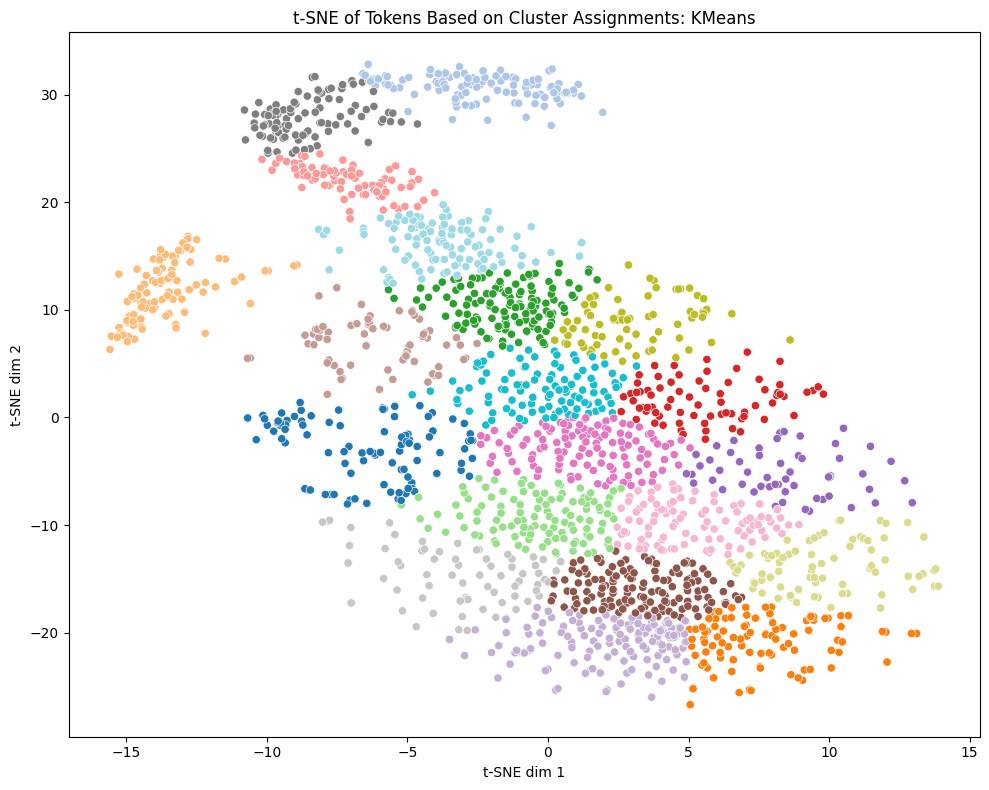

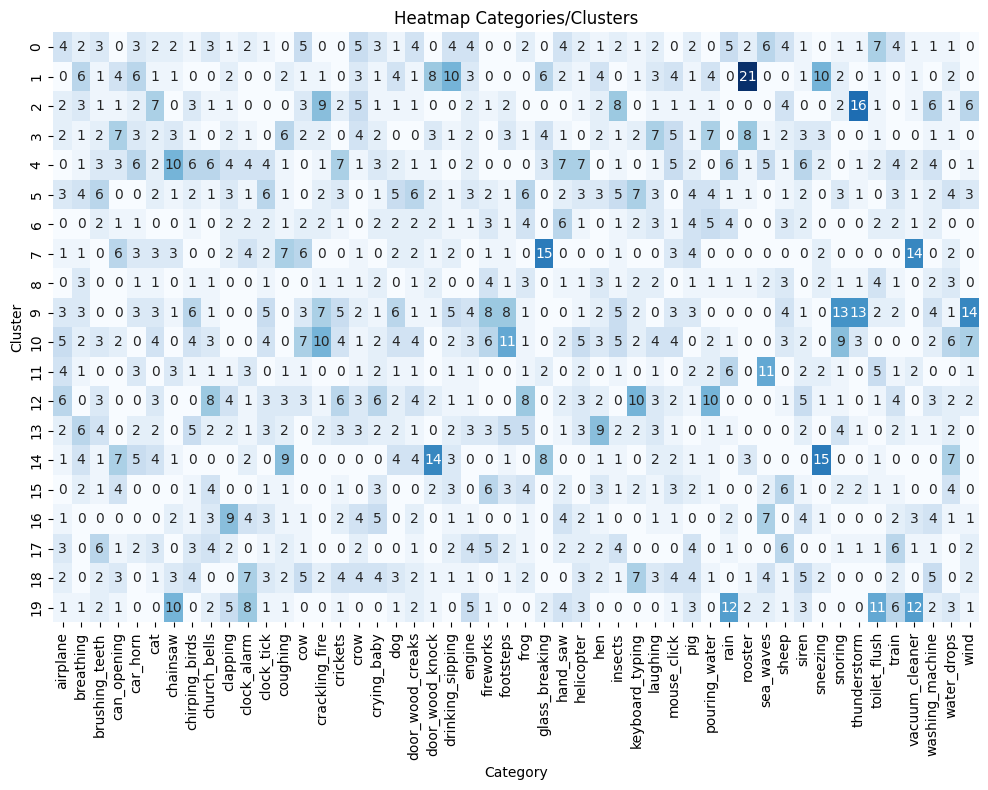

In [10]:
# TEST clustering sur embeddings resultant de la TSNE --- files ---
kmeans_tsne_files = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_tsne_files.fit(resh_tsne_files)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_files[:, 0], y=resh_tsne_files[:, 1], hue= kmeans_tsne_files.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: KMeans")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

"""
dbscan_tsne_files = DBSCAN(eps=0.5, min_samples=5)
dbscan_tsne_files.fit(resh_tsne_files)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_files[:, 0], y=resh_tsne_files[:, 1], hue= dbscan_tsne_files.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: DBSCAN")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

hdbscan_tsne_files = HDBSCAN(min_cluster_size=5)
hdbscan_tsne_files.fit(resh_tsne_files)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_tsne_files[:, 0], y=resh_tsne_files[:, 1], hue= hdbscan_tsne_files.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: HDBSCAN")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.tight_layout()
plt.show()

"""

kmeans_labels = kmeans_tsne_files.labels_

gt_cat = np.array(meta_df['category'])

cats_in_clusters =  pd.DataFrame({'cluster': kmeans_labels, 'category': gt_cat})

cluster_comp = pd.crosstab(cats_in_clusters['cluster'], cats_in_clusters['category'])

plt.figure(figsize=(10, 8))
sns.heatmap(cluster_comp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Heatmap Categories/Clusters")
plt.xlabel("Category")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

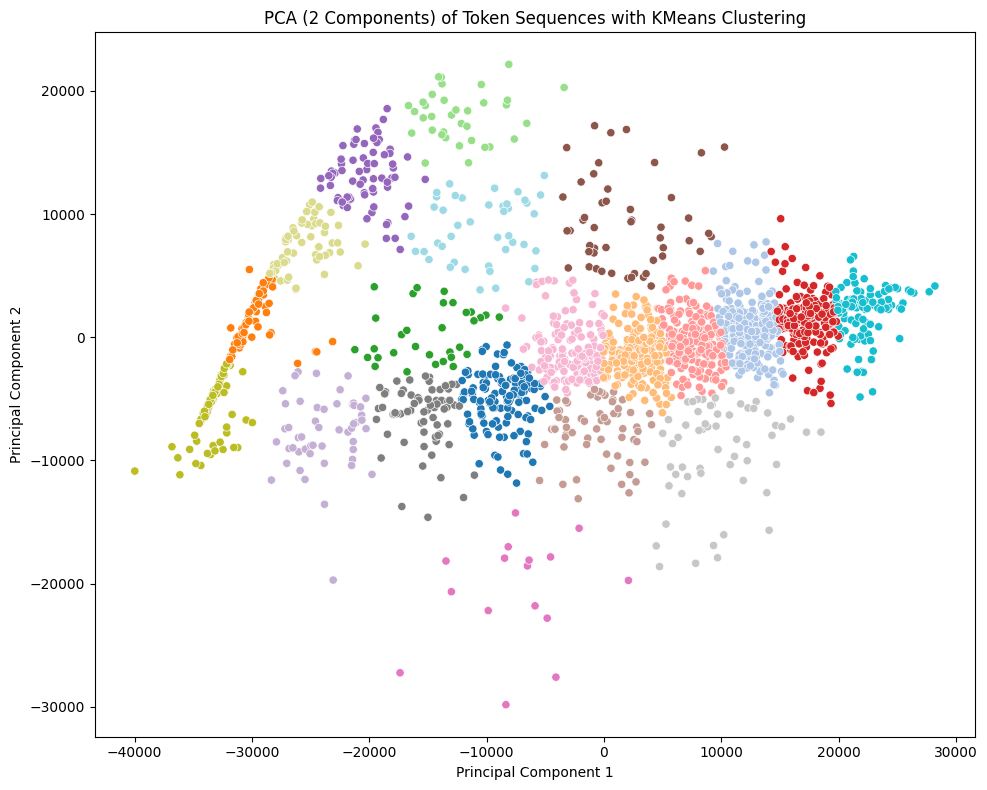

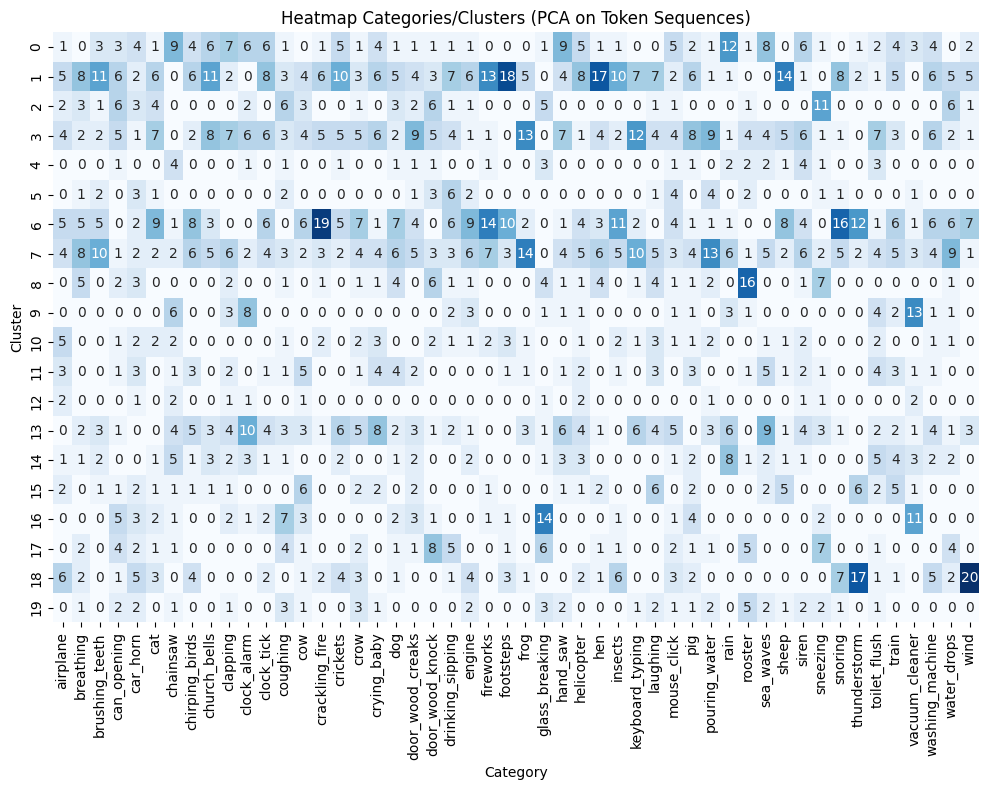

In [11]:
# TEST pca sur tok_seq
# Apply PCA to the entire tok_seq array
pca_seq = PCA(n_components=2)
tok_pca = pca_seq.fit_transform(tok_seq)

n_clusters = 20 # 20
# Initialise et entraîne un modèle KMeans sur les résultats de la PCA (les 2D embeddings par fichier)
kmeans_pca_seq = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Added n_init for robustness
kmeans_pca_seq.fit(tok_pca) # Fit KMeans on the 2D PCA results for each file

# Get the cluster labels for each file
kmeans_labels = kmeans_pca_seq.labels_

# Get the ground truth categories (assuming meta_df is still loaded and processed as before)
gt_cat = np.array(meta_df['category'])

# Create and display the scatter plot of the 2D PCA results colored by KMeans clusters
plt.figure(figsize=(10, 8))
# Use the 2D PCA transformed data for the scatter plot
sns.scatterplot(x=tok_pca[:, 0], y=tok_pca[:, 1], hue= kmeans_pca_seq.labels_, palette='tab20', legend=False)
plt.title("PCA (2 Components) of Token Sequences with KMeans Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.tight_layout()
plt.show()

# Create and display the heatmap of category distribution within clusters
cats_in_clusters =  pd.DataFrame({'cluster': kmeans_labels, 'category': gt_cat})
cluster_comp = pd.crosstab(cats_in_clusters['cluster'], cats_in_clusters['category'])

plt.figure(figsize=(10, 8))
sns.heatmap(cluster_comp, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Heatmap Categories/Clusters (PCA on Token Sequences)")
plt.xlabel("Category")
plt.ylabel("Cluster")
plt.tight_layout()
plt.show()

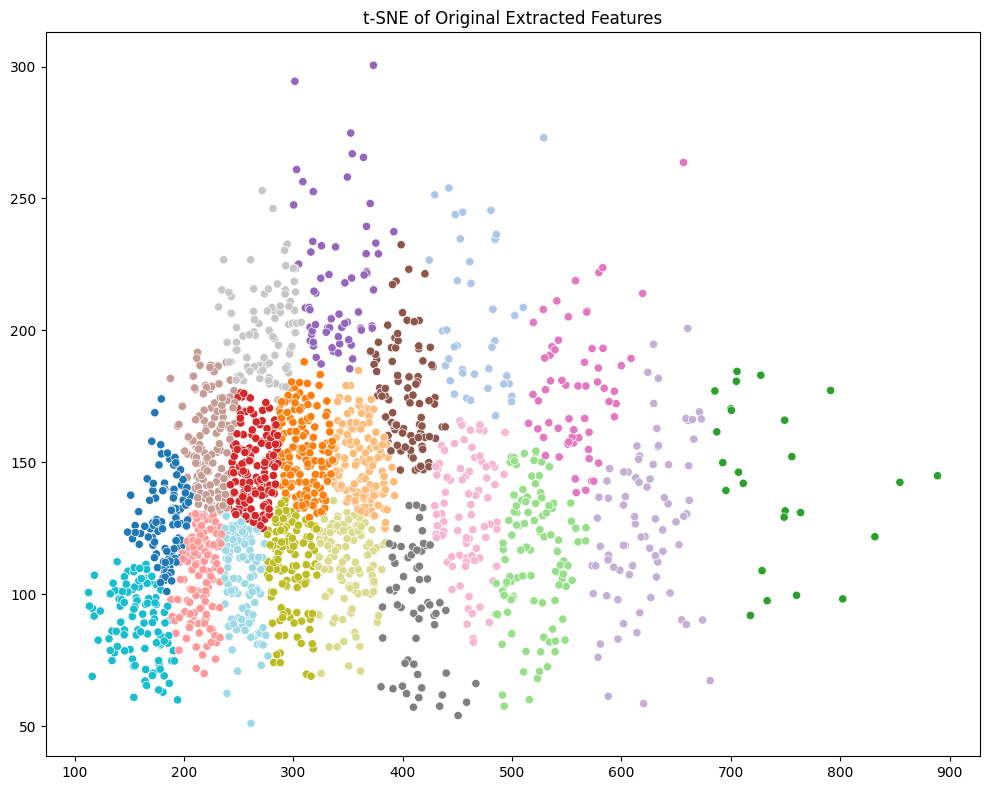

In [12]:
# Initialise une liste pour stocker les valeurs singulières de la PCA
tok_eighs = []
# Boucle sur chaque séquence de vecteurs du codebook par fichier
for seq in cb_vect_all:
  # Initialise un modèle PCA avec 2 composantes
  pca = PCA(n_components=2)
  # Applique la PCA sur la séquence
  pca.fit(seq)
  # Ajoute les valeurs singulières à la liste
  tok_eighs.append(pca.singular_values_)

# Initialise et entraîne un modèle KMeans sur les valeurs singulières
kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_pca.fit(tok_eighs)

# Convertit la liste des valeurs singulières en tableau NumPy
tok_eighs_np = np.array(tok_eighs)
# Crée une figure pour le graphique
plt.figure(figsize=(10, 8))
# Crée un scatter plot des valeurs singulières colorées par les clusters KMeans
sns.scatterplot(x=tok_eighs_np[:, 0], y=tok_eighs_np[:, 1], hue= kmeans_pca.labels_, palette='tab20', legend=False)
# Définit le titre du graphique
plt.title("t-SNE of Original Extracted Features")

# Ajuste automatiquement les paramètres du subplot pour que le graphique s'adapte à la figure
plt.tight_layout()
# Affiche le graphique
plt.show()

# BEATs

In [13]:
# On télécharge le dossier comprésé contenant les tokens calculés au préalable
%cd /content/
import os
!wget https://raw.githubusercontent.com/GhilesREDJDAL/Projet-M1-ISI-SSL-paysages-sonores/main/esc50_tokens_BEATs.zip
zip_path = "/content/esc50_tokens_BEATs.zip"

# Extraction des tokens (si téléchargés)
if not os.path.exists(zip_path):
    print("Le fichier n'existe pas.")
else:
    print("Le fichier existe.")
    !unzip {zip_path} -d /content

/content
--2025-06-20 12:54:23--  https://raw.githubusercontent.com/GhilesREDJDAL/Projet-M1-ISI-SSL-paysages-sonores/main/esc50_tokens_BEATs.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5817172 (5.5M) [application/zip]
Saving to: ‘esc50_tokens_BEATs.zip’

esc50_tokens_BEATs. 100%[===================>]   5.55M  --.-KB/s    in 0.09s   

2025-06-20 12:54:23 (62.3 MB/s) - ‘esc50_tokens_BEATs.zip’ saved [5817172/5817172]

Le fichier existe.
Archive:  /content/esc50_tokens_BEATs.zip
   creating: /content/esc50_tokens_BEATs/
  inflating: /content/esc50_tokens_BEATs/1-100032-A-0.pt  
  inflating: /content/esc50_tokens_BEATs/1-100038-A-14.pt  
  inflating: /content/esc50_tokens_BEATs/1-100210-A-36.pt  
  inflating: /content/esc50_tokens_BEATs/1-100210-B-36.pt 

In [ ]:
# Trouver façon de charger le modèle directement sur Colab, !wget du lien onedrive ne marche pas (upload le modele sur le github?)
#!wget https://my.microsoftpersonalcontent.com/personal/6b83b49411ca81a7/_layouts/15/download.aspx?UniqueId=11ca81a7-b494-2083-806b-696500000000&Translate=false&tempauth=v1e.eyJzaXRlaWQiOiJlNmU2YThhZi0yOWNmLTRhYjMtYmM2Zi05ODFmNTRlZmVhOWYiLCJhdWQiOiIwMDAwMDAwMy0wMDAwLTBmZjEtY2UwMC0wMDAwMDAwMDAwMDAvbXkubWljcm9zb2Z0cGVyc29uYWxjb250ZW50LmNvbUA5MTg4MDQwZC02YzY3LTRjNWItYjExMi0zNmEzMDRiNjZkYWQiLCJleHAiOiIxNzUwMjUxNjE0In0.2akpMpyG1y3JtFSp53yJza6t74O2ozg3bX0EU61Soxau3nsh8K39tWXrjP0FrL9jABGfXnNilHBR_CS4QZFyOa62DrpPMgnfphPpe8D0NsVNIwocwKmU-Z1GT5ztDY2Fb_QR49mx6jKq_RtA8oKyLohkJFoG6H_wN6ztUXPkpSITuH55MmPIRTYRl26p9tiI4l_sQ5NhdKHTW6vbf-bFaeKJVDtgZg_ueVkwYTqdF4SOPOhzo5Kt0F2Y6-YKkKlxssS95y8vBRyBBf4HILo1_EkhpUgSQD91z8gOSsPLqlGlbXK4UJ8USCi27k2gCyttpre9IhJgQPKJaXyqI2xU3NDta1OMahg4ZafuLtWUzDXQS-TKYHuwzC3MEEAkVpC3hVA4Qkis-QQAXsx7WWKeq2cVz-mbBV9J-iFCdGY42m4w4QjQhMdl7SiVEgi-zojnqLpSEBLt_T1LDgM0SL5TE9mx57cMI6csP1KRfRgBC9ts9AAyGwEM6rmbxPGXk2AcjHrDb1kZA7iR2O0RecMW3Q.m7oiVs3DWZRhrzEvn_dFkxWV6o-Aou53Z6MeherQMnE&ApiVersion=2.0

In [14]:
import os
import torch
import librosa
import pandas as pd
from transformers import Wav2Vec2FeatureExtractor, AutoTokenizer
!git clone https://github.com/microsoft/unilm.git

%cd /content/unilm/beats
from Tokenizers import TokenizersConfig, Tokenizers
%cd /content/

Cloning into 'unilm'...
remote: Enumerating objects: 11178, done.
remote: Counting objects: 100% (40/40), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 11178 (delta 30), reused 18 (delta 18), pack-reused 11138 (from 3)
Receiving objects: 100% (11178/11178), 75.40 MiB | 36.89 MiB/s, done.
Resolving deltas: 100% (5293/5293), done.
/content/unilm/beats
/content


In [ ]:
checkpoint = torch.load('/content/Tokenizer_iter3_plus_AS2M.pt')

cfg = TokenizersConfig(checkpoint['cfg'])
BEATs_tokenizer = Tokenizers(cfg)
BEATs_tokenizer.load_state_dict(checkpoint['model'])
BEATs_tokenizer.eval()

In [16]:
test = torch.load('/content/esc50_tokens_BEATs/1-100032-A-0.pt')
print(test.shape)

torch.Size([688])


In [17]:
beats_tokens_dir = '/content/esc50_tokens_BEATs'
beats_tok_seq = []
for fname in tqdm(os.listdir(beats_tokens_dir)):
    # Ignore les fichiers qui ne se terminent pas par '.pt'
    if not fname.endswith('.pt'):
        continue

    tok_path = os.path.join(beats_tokens_dir, fname)
    # Charge les tokens à partir du fichier
    tokens = torch.load(tok_path)
    beats_tok_seq.append(tokens.squeeze())

beats_tok_seq = np.vstack(beats_tok_seq)

100%|██████████| 2001/2001 [00:00<00:00, 4441.55it/s]


In [18]:
print(beats_tok_seq.shape)

(2000, 688)


In [19]:
resh_beats_tsne = TSNE(n_components=2, perplexity=40, random_state=42).fit_transform(beats_tok_seq)

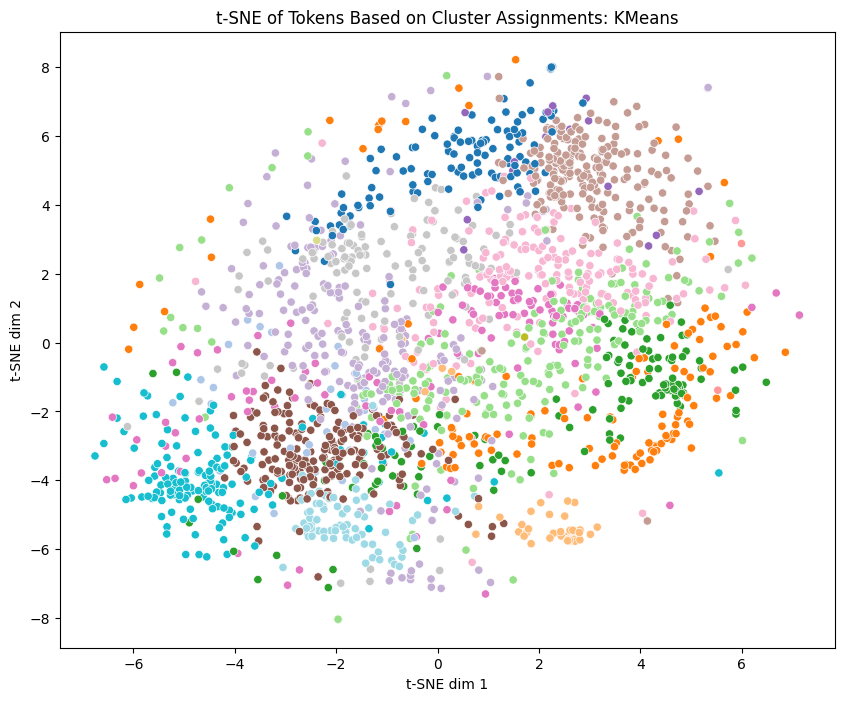

In [20]:
n_clusters = 20
kmeans_beats_seq = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_beats_seq.fit(beats_tok_seq)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_beats_tsne[:, 0], y=resh_beats_tsne[:, 1], hue= kmeans_beats_seq.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: KMeans")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()

# """
# dbscan_beats_seq = DBSCAN(eps=0.5, min_samples=5)
# dbscan_beats_seq.fit(beats_tok_seq)

# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=resh_beats_tsne[:, 0], y=resh_beats_tsne[:, 1], hue= dbscan_beats_seq.labels_, palette='tab20', legend=False)
# plt.title("t-SNE of Tokens Based on Cluster Assignments: DBSCAN")
# plt.xlabel("t-SNE dim 1")
# plt.ylabel("t-SNE dim 2")
# plt.show()

# hdbscan_beats_seq = HDBSCAN(min_cluster_size=5)
# hdbscan_beats_seq.fit(beats_tok_seq)

# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=resh_beats_tsne[:, 0], y=resh_beats_tsne[:, 1], hue= hdbscan_beats_seq.labels_, palette='tab20', legend=False)
# plt.title("t-SNE of Tokens Based on Cluster Assignments: HDBSCAN")
# plt.xlabel("t-SNE dim 1")
# plt.ylabel("t-SNE dim 2")
# plt.show()
# """

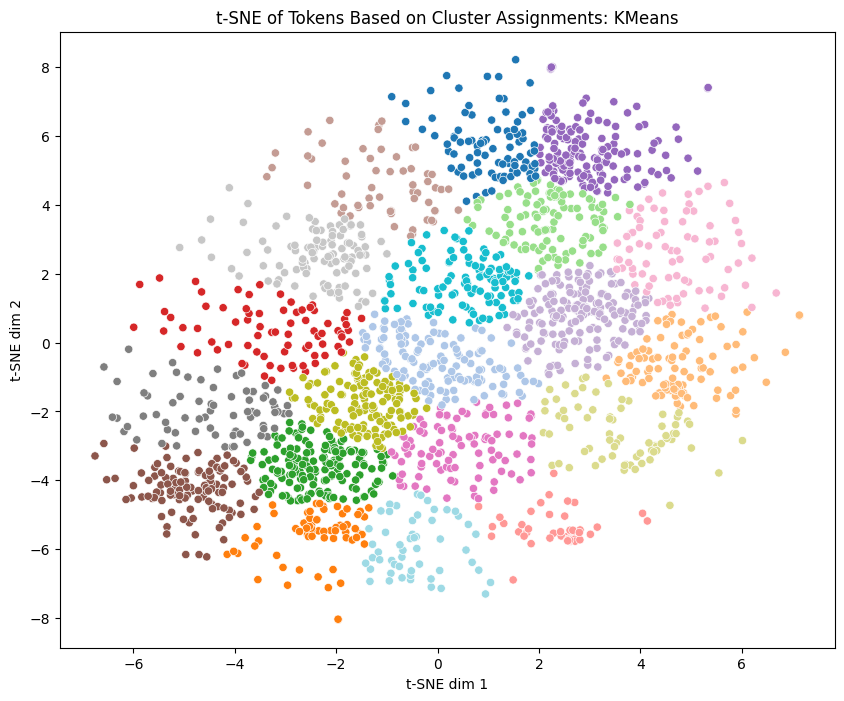

In [21]:
n_clusters = 20
kmeans_beats_tsne = KMeans(n_clusters=n_clusters, random_state=42)
kmeans_beats_tsne.fit(resh_beats_tsne)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=resh_beats_tsne[:, 0], y=resh_beats_tsne[:, 1], hue= kmeans_beats_tsne.labels_, palette='tab20', legend=False)
plt.title("t-SNE of Tokens Based on Cluster Assignments: KMeans")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.show()

# """
# dbscan_beats_tsne = DBSCAN(eps=0.5, min_samples=5)
# dbscan_beats_tsne.fit(resh_beats_tsne)

# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=resh_beats_tsne[:, 0], y=resh_beats_tsne[:, 1], hue= dbscan_beats_tsne.labels_, palette='tab20', legend=False)
# plt.title("t-SNE of Tokens Based on Cluster Assignments: DBSCAN")
# plt.xlabel("t-SNE dim 1")
# plt.ylabel("t-SNE dim 2")
# plt.show()

# hdbscan_beats_tsne = HDBSCAN(min_cluster_size=5)
# hdbscan_beats_tsne.fit(resh_beats_tsne)

# plt.figure(figsize=(10, 8))
# sns.scatterplot(x=resh_beats_tsne[:, 0], y=resh_beats_tsne[:, 1], hue= hdbscan_beats_tsne.labels_, palette='tab20', legend=False)
# plt.title("t-SNE of Tokens Based on Cluster Assignments: HDBSCAN")
# plt.xlabel("t-SNE dim 1")
# plt.ylabel("t-SNE dim 2")
# plt.show()
# """

In [ ]:
print(dir(BEATs_tokenizer))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hoo

In [ ]:
%cd /content/unilm/beats
from BEATs import BEATs, BEATsConfig
%cd /content/

# load the fine-tuned checkpoints
checkpoint = torch.load('/content/BEATs_iter3_plus_AS2M_finetuned_on_AS2M_cpt2.pt')

cfg = BEATsConfig(checkpoint['cfg'])
BEATs_model = BEATs(cfg)
BEATs_model.load_state_dict(checkpoint['model'])
BEATs_model.eval()

In [ ]:
print(dir(BEATs_model))

['T_destination', '__annotations__', '__call__', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_apply', '_backward_hooks', '_backward_pre_hooks', '_buffers', '_call_impl', '_compiled_call_impl', '_forward_hooks', '_forward_hooks_always_called', '_forward_hooks_with_kwargs', '_forward_pre_hooks', '_forward_pre_hooks_with_kwargs', '_get_backward_hooks', '_get_backward_pre_hooks', '_get_name', '_is_full_backward_hook', '_load_from_state_dict', '_load_state_dict_post_hooks', '_load_state_dict_pre_hooks', '_maybe_warn_non_full_backward_hook', '_modules', '_named_members', '_non_persistent_buffers_set', '_parameters', '_register_load_state_dict_pre_hoo

In [22]:
test = torch.load('/content/esc50_tokens_BEATs/1-100032-A-0.pt')
print(test)

tensor([243, 881, 881, 881, 881, 881, 881, 881, 881, 881, 881, 881, 881, 881,
        881, 881, 881, 881, 881, 881, 881, 881, 881, 881, 881, 881, 881, 881,
        881, 881, 881, 881, 394, 394, 394, 394, 394, 394, 394, 394, 394, 394,
        394, 394, 394, 394, 881, 881, 618, 232, 394, 394, 394, 394, 394, 394,
        394, 394, 436, 394, 436, 394, 394, 394, 394, 394, 394, 394,  21,  21,
         21,  21, 394, 394, 394, 394, 394, 394, 394, 394, 881, 394, 881, 881,
        881, 394, 881, 881, 881, 881, 394, 394, 394, 394, 394, 394, 394, 394,
        394, 394, 394, 394, 232, 394, 394, 394, 394, 394, 394, 394, 881, 881,
        881, 618, 394, 881, 394, 394, 394, 881, 394, 618,  21, 394, 394, 394,
        394, 881, 394, 394, 232, 394, 394, 618, 618, 618, 137, 137, 394, 394,
        394, 881, 881, 881, 881, 618, 881, 881, 881, 394, 881, 394, 137, 394,
        394, 394, 881, 881, 394, 881, 394, 394, 881, 881, 881, 881, 394, 436,
        137, 137, 232, 394, 881, 881, 881, 881, 394, 137, 618, 6

TO FINISH: beats extract features (trouver accès codebook? -> possible de modifié le code Tokenizer.py->extract_labels et retouner les features?) etc. Wav -> dict: fname, toks, tsne/pca embeddings, class/cat